<a href="https://colab.research.google.com/github/job-moses/FashionProductClassifier/blob/main/FashionProductClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepVision: Convolutional Neural Networks for Fashion Product Classification

## Introduction

In an era defined by the convergence of technology and fashion, the ability to swiftly and accurately classify fashion products has become paramount for e-commerce platforms, trend analysts, and fashion enthusiasts alike. Leveraging the transformative power of deep learning, this project, titled "DeepVision," endeavors to address this challenge through the application of Convolutional Neural Networks (CNNs) for fashion product classification.



## Information on the Dataset
The dataset used to in this project is a kaggle dataset available [here](https://www.kaggle.com/paramaggarwal/fashion-product-images-small'). The dataset was downloades via opendataset library using my kaggle API

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/paramaggarwal/fashion-product-images-small')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mosesubehjob
Your Kaggle Key: ··········


100%|██████████| 565M/565M [00:14<00:00, 41.3MB/s]


As we can see, the data has been downloaded now let navigate into the folder

In [5]:
%cd fashion-product-images-small

/content/fashion-product-images-small


In [91]:
%ls #list files in the folder

best_model.h5  images/  myntradataset/  styles.csv


There are three files in the folder, but we are interested in the **images** folder and **styles.css** file. The images will wil use to train the model is in the image folder while styles.css file contains information about each of the images, here i will read the styles.css file but only choose the **id** and **masterCategory** which is the target for the classification

In [6]:
import pandas as pd #library for data manipulation


In [7]:
df = pd.read_csv('styles.csv', usecols= ['id','masterCategory']) #reading styles.csv file

In [8]:
df.head() #first five rows of dataframe

,id,masterCategory
0,15970,Apparel
1,39386,Apparel
2,59263,Accessories
3,21379,Apparel
4,53759,Apparel


Since the images are in **.jpg** extension, i will create a new column by  concating the the **id** column with with .jpg extension for easy augumentation and preprocesing

In [9]:
 df['images'] = df['id'].astype('str') +'.jpg'

In [10]:
df = df.sample( frac = 1)

In [13]:
df.sample(5)

,id,masterCategory,images
8096,20325,Apparel,20325.jpg
31167,5748,Apparel,5748.jpg
32058,50238,Accessories,50238.jpg
8919,39862,Apparel,39862.jpg
37450,54679,Accessories,54679.jpg


## Image Preprocessing

In [11]:
# importing library for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
image_genarator= ImageDataGenerator( validation_split=0.2)
batch_size = 256

In [18]:
train_gen = image_genarator.flow_from_dataframe(
    dataframe = df,
    x_col = 'images',
    y_col = 'masterCategory',
    target_size = (60,80),
    batch_size = batch_size,
    directory = 'images',
    subset = 'training'

)

test_gen = image_genarator.flow_from_dataframe(
    dataframe= df,
    x_col = 'images',
    y_col = 'masterCategory',
    target_size = (60,80),
    batch_size = batch_size,
    directory = 'images',
    subset = 'validation'

)
train_gen.class_indices

Found 35553 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 5 invalid image filename(s) in x_col="images". These filename(s) will be ignored.
  warnings.warn(


Found 8888 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 5 invalid image filename(s) in x_col="images". These filename(s) will be ignored.
  warnings.warn(


{'Accessories': 0,
 'Apparel': 1,
 'Footwear': 2,
 'Free Items': 3,
 'Home': 4,
 'Personal Care': 5,
 'Sporting Goods': 6}

As we can see there are seven **7** classes of fashion product that we want to build the model on

**Model Building**

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [28]:
model = models.Sequential([
    layers.Conv2D(32 , (3,3),activation = 'relu', input_shape = (60,80,3)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128,(3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation = 'softmax')

])

model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [29]:
from math import ceil
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks to altomatically save the optimal parameter for our model,this model will be save as best_modelin our file directory
early_stopping = EarlyStopping( patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# fit model on train and validation data
model_history = model.fit_generator(
    generator = train_gen,
    steps_per_epoch = ceil( 0.8 * (df.shape[0]/batch_size)),
    validation_data = test_gen,
    validation_steps = ceil(0.2 * (df.shape[0]/batch_size)),
    epochs = 10,
    verbose = 1,
    callbacks=[early_stopping, model_checkpoint]
)


<ipython-input-29-e11d6169db8e>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/10
139/139 [==============================] - 379s 3s/step - loss: 2.7557 - accuracy: 0.7937 - val_loss: 0.2547 - val_accuracy: 0.9272


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
139/139 [==============================] - 372s 3s/step - loss: 0.3078 - accuracy: 0.9007 - val_loss: 0.2031 - val_accuracy: 0.9436
Epoch 3/10
139/139 [==============================] - 376s 3s/step - loss: 0.2599 - accuracy: 0.9170 - val_loss: 0.1707 - val_accuracy: 0.9541
Epoch 4/10
139/139 [==============================] - 360s 3s/step - loss: 0.2198 - accuracy: 0.9313 - val_loss: 0.1427 - val_accuracy: 0.9576
Epoch 5/10
139/139 [==============================] - 359s 3s/step - loss: 0.1969 - accuracy: 0.9394 - val_loss: 0.1242 - val_accuracy: 0.9669
Epoch 6/10
139/139 [==============================] - 360s 3s/step - loss: 0.1842 - accuracy: 0.9434 - val_loss: 0.1214 - val_accuracy: 0.9652
Epoch 7/10
139/139 [==============================] - 346s 2s/step - loss: 0.1617 - accuracy: 0.9487 - val_loss: 0.1135 - val_accuracy: 0.9682
Epoch 8/10
139/139 [==============================] - 362s 3s/step - loss: 0.1519 - accuracy: 0.9529 - val_loss: 0.1176 - val_accuracy: 0.9661

## Load  model for prediction

In [30]:
model = models.load_model('best_model.h5')

here i evaluted the model on test data which was define earlier in the preprocessing stage

In [32]:
model.evaluate_generator(test_gen,  steps=ceil(0.2 * (df.size / batch_size)))

<ipython-input-32-e8078aac54ff>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_gen,  steps=ceil(0.2 * (df.size / batch_size)))


[0.09307990223169327, 0.9735598564147949]

as we can see the model has 97.355% accurary on the test set

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 58, 78, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 29, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 37, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 18, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 16, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 5, 8, 128)        

now our model is ready, let use it to predict a new image, I will be use the first image in our dataset for prediction

In [35]:
import matplotlib.pyplot as plt
import numpy as np

In [55]:
df.head()

,id,masterCategory,images
35009,6585,Apparel,6585.jpg
29717,56306,Apparel,56306.jpg
1205,56222,Apparel,56222.jpg
1880,9408,Accessories,9408.jpg
20017,52067,Apparel,52067.jpg


In [71]:
df.values[1,2]

'56306.jpg'

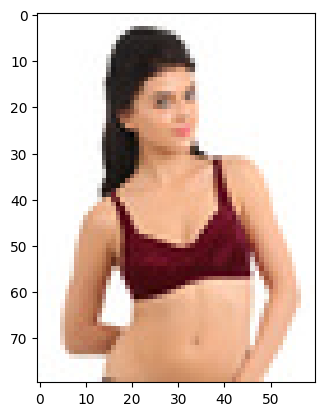

In [73]:
plt.imshow(plt.imread('images/56306.jpg'))

as we can see the first image is an **Apparel** let load this image and see if the model will be able to recognize this image as an apparel

In [1]:

from keras.preprocessing import image
new_image = image.load_img('images/56306.jpg',target_size=(60,80))
test_image = image.img_to_array(new_image)
test_image = np.expand_dims(test_image, axis = 0)
pred_result = model.predict(test_image)
val = np.argmax(pred_result)
my_dict = train_gen.class_indices
key_list = list(my_dict.keys())
val_list = list(my_dict.values())
print(key_list[val])

FileNotFoundError: [Errno 2] No such file or directory: 'images/56306.jpg'

Waw,the model recogize the image as an apparel, our model is ready for fashion product classification, Moving forward, we will explore aspects such as model testing, validation, documentation, deployment planning, monitoring, maintenance, security considerations, and communication.

in conclusion,The aim of the project to utilize deep learning model such as convolutional neural network to classify fashion image product as been achieved.
The model was save for futher fashion product prediction.